In [49]:
import pandas as pd 
import numpy as np 
import matplotlib.pyplot as plt
import seaborn as sns 
from sklearn.preprocessing import LabelEncoder
from sklearn.tree import DecisionTreeClassifier #(for featrure importance)

plt.rcParams["figure.figsize"] = (12,6)
sns.set_style("whitegrid")

In [50]:
# data loading
df = pd.read_csv("btc_1h_data_2018_to_2025.csv")

df.head()

df.info()
df.describe()
print("Shape: ", df.shape)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 70823 entries, 0 to 70822
Data columns (total 12 columns):
 #   Column                        Non-Null Count  Dtype  
---  ------                        --------------  -----  
 0   Open time                     70822 non-null  object 
 1   Open                          70823 non-null  float64
 2   High                          70823 non-null  float64
 3   Low                           70823 non-null  float64
 4   Close                         70823 non-null  float64
 5   Volume                        70823 non-null  float64
 6   Close time                    70822 non-null  object 
 7   Quote asset volume            70823 non-null  float64
 8   Number of trades              70823 non-null  int64  
 9   Taker buy base asset volume   70823 non-null  float64
 10  Taker buy quote asset volume  70823 non-null  float64
 11  Ignore                        70823 non-null  int64  
dtypes: float64(8), int64(2), object(2)
memory usage: 6.5+ MB
Sha

In [51]:
df.columns

Index(['Open time', 'Open', 'High', 'Low', 'Close', 'Volume', 'Close time',
       'Quote asset volume', 'Number of trades', 'Taker buy base asset volume',
       'Taker buy quote asset volume', 'Ignore'],
      dtype='object')

In [52]:
#valiation check for datatime 
df['Open time'] = pd.to_datetime(df['Open time'])
df = df.sort_values('Open time')
print("Date range: ", df['Open time'].min(), " to ", df['Open time'].max())

Date range:  2018-01-01 00:00:00  to  2026-02-03 21:00:00


In [53]:
#missing value check
df.isnull().sum()
df[df['Open time'].isnull()]
df = df.dropna(subset=['Open', 'High', 'Low', 'Close', 'Volume'])
print("Shape after dropping missing values: ", df.shape)

Shape after dropping missing values:  (70823, 12)


In [54]:
#duplicate removal
df = df.drop_duplicates()
#invalid price filtering
df = df[(df[['Open', 'High', 'Low', 'Close', 'Volume']] > 0).all(axis=1)]
print("Shape after removing duplicates and invalid prices: ", df.shape)

Shape after removing duplicates and invalid prices:  (70820, 12)


In [55]:
# Data Visulaization(I choose year of 2025)

In [56]:
df_2025 = df[df['Open time'].dt.year == 2025].copy()
print("2025 data shape: ", df_2025.shape)
len(df_2025)

2025 data shape:  (8760, 12)


8760

In [57]:
df_2025.isnull().sum() #<--- checking missing values)

Open time                       0
Open                            0
High                            0
Low                             0
Close                           0
Volume                          0
Close time                      0
Quote asset volume              0
Number of trades                0
Taker buy base asset volume     0
Taker buy quote asset volume    0
Ignore                          0
dtype: int64

In [58]:
df_2025 = df_2025.dropna(
    subset=['Open','High','Low','Close','Volume']
)
df_2025 = df_2025.drop_duplicates()
df_2025 = df_2025[df_2025['High'] >= df_2025['Low']]

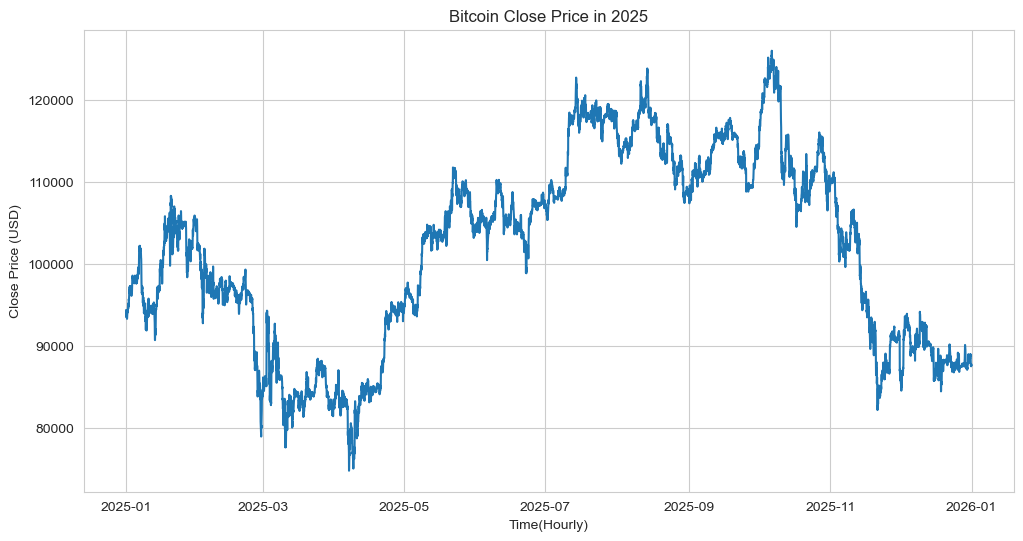

In [59]:
# Time series price behaviour

plt.plot(df_2025['Open time'], df_2025['Close'])
plt.title("Bitcoin Close Price in 2025")
plt.xlabel("Time(Hourly)")
plt.ylabel("Close Price (USD)")
plt.show()

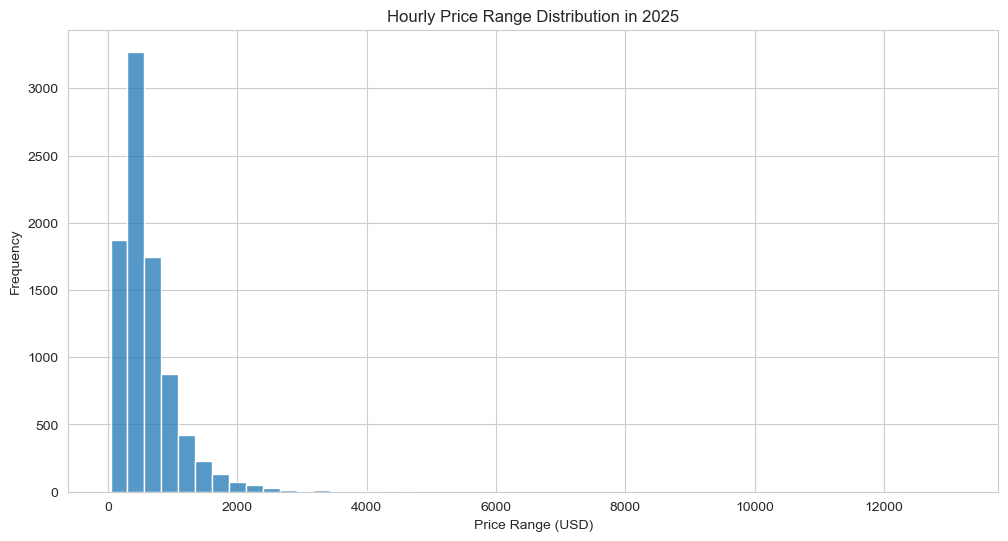

In [60]:
# Price Chaging Distribution

df_2025['Price_Range'] = df_2025['High'] - df_2025['Low']
sns.histplot(df_2025['Price_Range'], bins=50)
plt.title("Hourly Price Range Distribution in 2025")
plt.xlabel("Price Range (USD)")
plt.ylabel("Frequency")
plt.show()

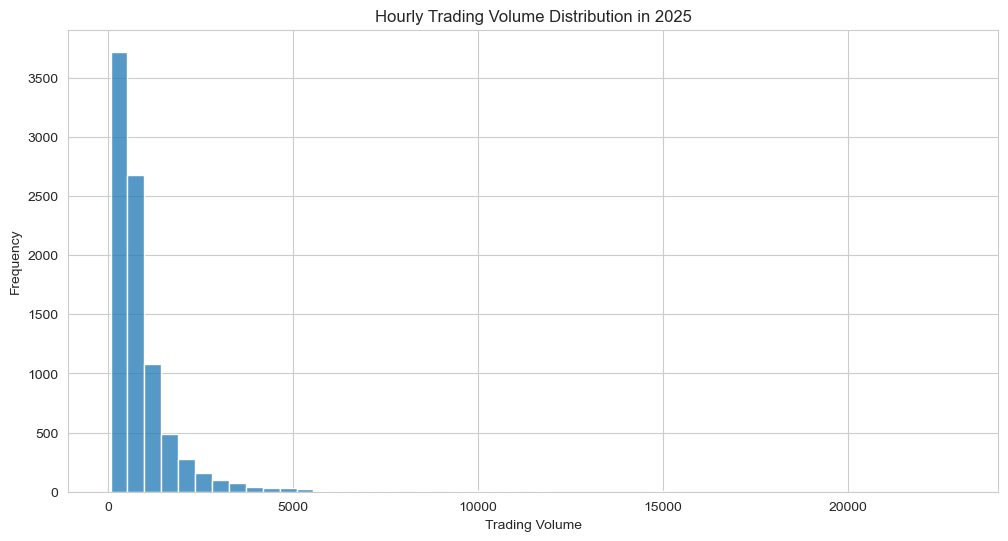

In [61]:
# Trading volume distribution

sns.histplot(df_2025['Volume'], bins=50)
plt.title("Hourly Trading Volume Distribution in 2025")
plt.xlabel("Trading Volume")
plt.ylabel("Frequency")
plt.show()

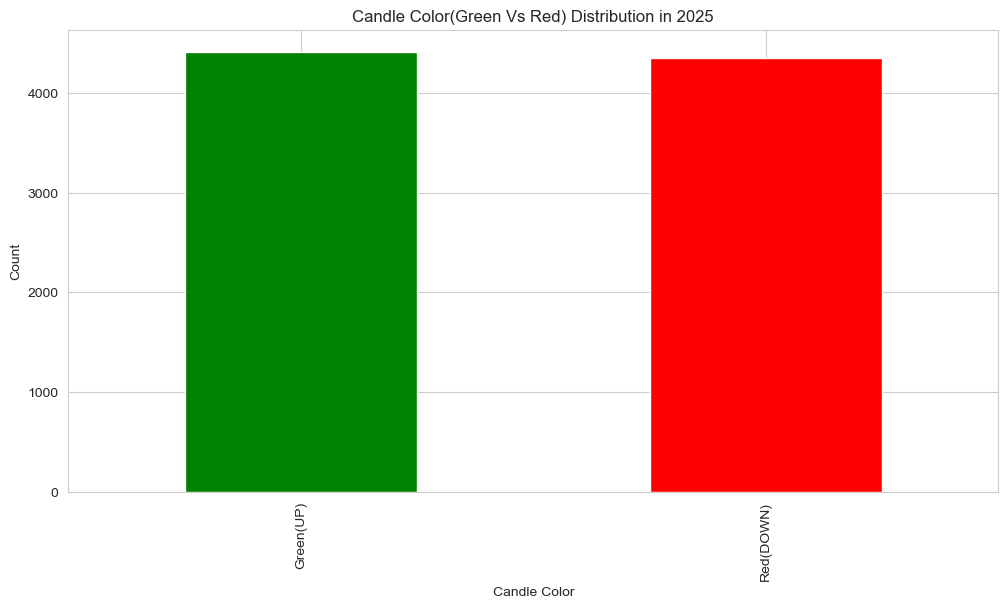

In [62]:
#Trend direction distribution(Green/Red candles)

df_2025['Candle_Color'] = np.where(df_2025['Close'] >= df_2025['Open'], 'Green(UP)', 'Red(DOWN)')
df_2025['Candle_Color'].value_counts().plot(kind='bar', color=['green', 'red'])
# counts, bin_edges = np.histogram(df_2025['Candle_Color'].map({'Green(UP)':1, 'Red(DOWN)':0}))
# print(counts)
# print(bin_edges)
plt.title("Candle Color(Green Vs Red) Distribution in 2025")
plt.xlabel("Candle Color")
plt.ylabel("Count")
plt.show()

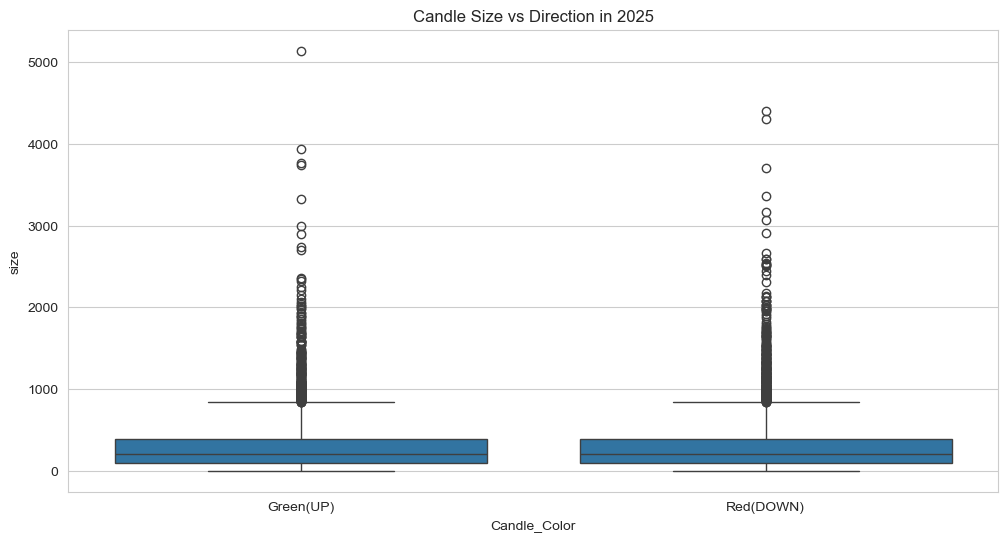

In [63]:
#Feature vs Direction

df_2025['size'] = abs(df_2025['Close'] - df_2025['Open'])
sns.boxplot(x='Candle_Color', y='size', data=df_2025)
plt.title("Candle Size vs Direction in 2025")
plt.show()

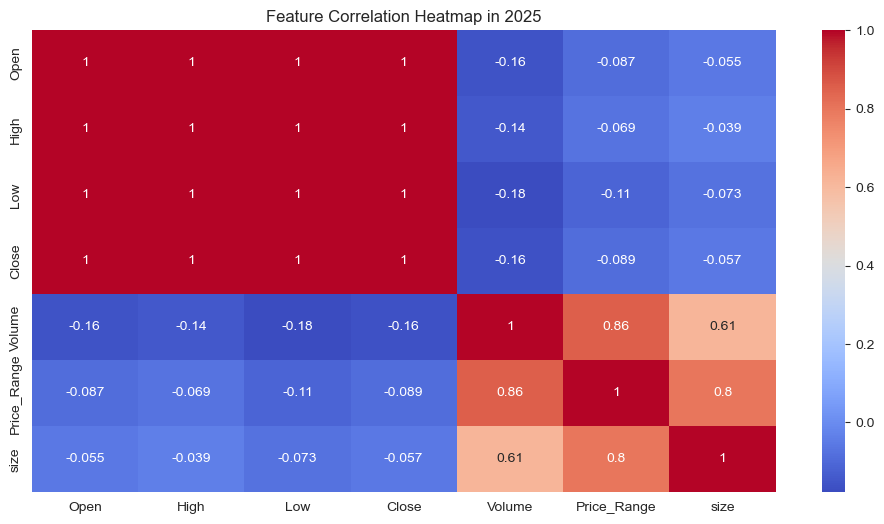

In [64]:
#feature relationship(correlation heatmap)

features = ['Open', 'High', 'Low', 'Close', 'Volume', 'Price_Range', 'size']
corr = df_2025[features].corr()
sns.heatmap(corr, annot=True, cmap='coolwarm')
plt.title("Feature Correlation Heatmap in 2025")
plt.show()

In [65]:
#Feature	Hourly Meaning
#price_range	How much price fluctuated within the hour
#body_size	Strength of movement in that hour
#return	Direction + size of that hour
#log_return	Stable version of hourly return

In [66]:
# Data Transformation(Feature Engineering)

df_2025['return'] = (df_2025['Close'] - df_2025['Open']) / df_2025['Open']
df_2025['log_return'] = np.log(df_2025['Close'] / df_2025['Open'])

df_2025[['Price_Range', 'size', 'return', 'log_return']].describe()

,Price_Range,size,return,log_return
count,8760.000000,8760.000000,8760.000000,8760.000000
mean,620.011421,304.980894,0.000004,-0.000007
std,489.040409,348.846852,0.004748,0.004750
min,41.580000,0.010000,-0.048955,-0.050194
25%,327.430000,90.920000,-0.001944,-0.001946
50%,491.690000,202.965000,0.000026,0.000026
75%,765.760000,389.775000,0.002057,0.002054
max,13112.690000,5142.300000,0.050269,0.049047


In [67]:
#Feature Selection and Reduction

#For direction
le = LabelEncoder()
y = le.fit_transform(df_2025['Candle_Color'])
X = df_2025[['Volume', 'Price_Range', 'size', 'return', 'log_return']]

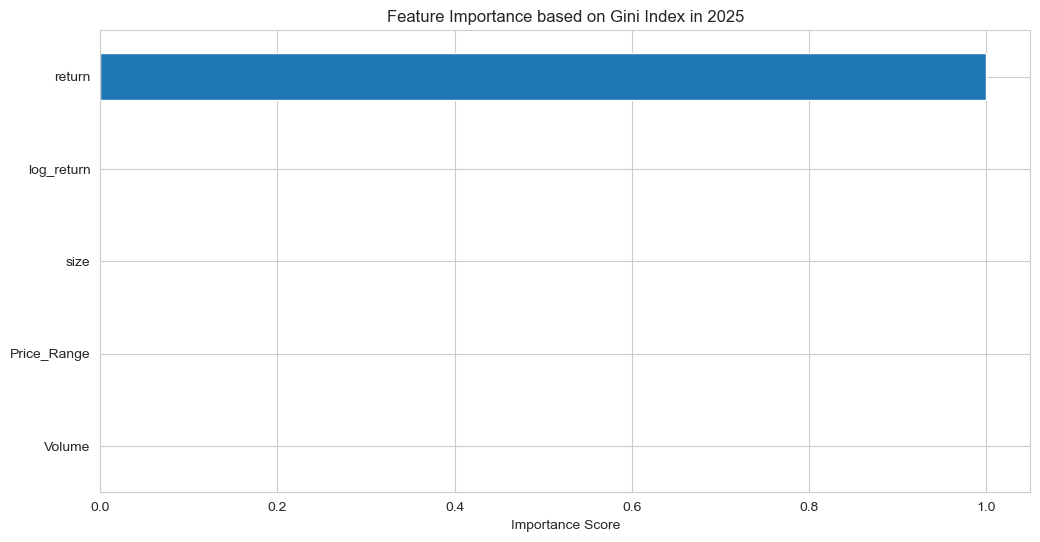

In [68]:
# Gini based feature importance

dt = DecisionTreeClassifier(criterion='gini', random_state=42)
dt.fit(X, y)
importances = pd.Series(dt.feature_importances_, index = X.columns)
importances.sort_values(ascending = False)
importances.sort_values().plot(kind='barh')
plt.title("Feature Importance based on Gini Index in 2025")
plt.xlabel("Importance Score")
plt.show()

In [ ]:
selected_features = importances.index[:5].tolist()
final_df = df_2025[selected_features].copy()
final_df.to_csv("cryptoflow_hourly_features_2025.csv", index=False)
print(final_df.head())

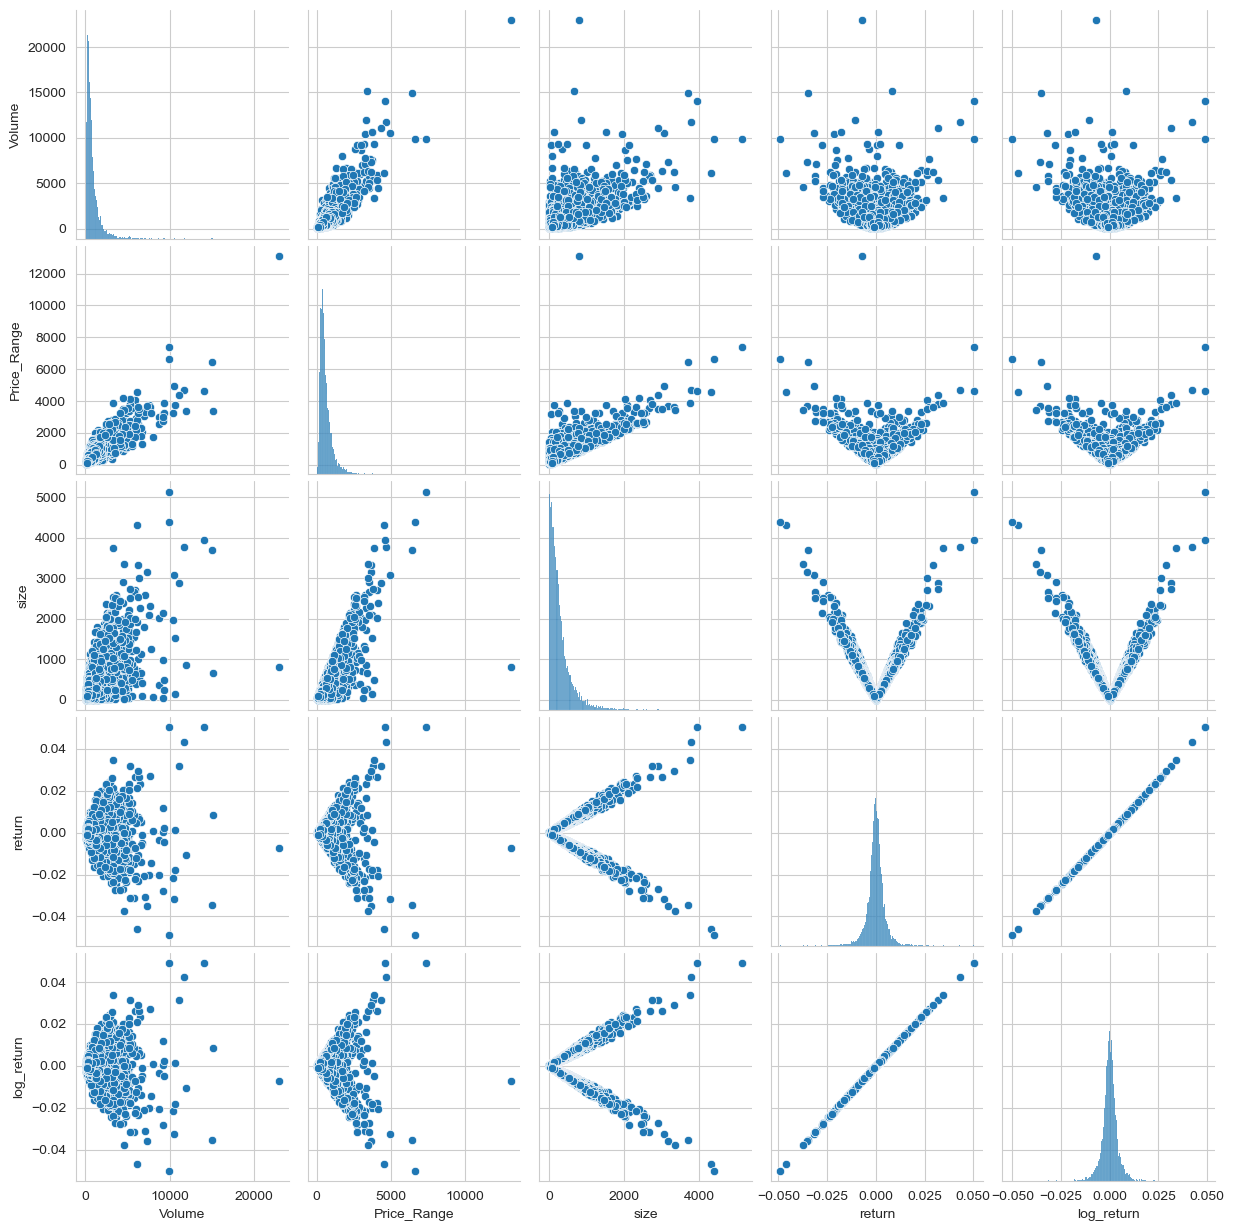

In [70]:
sns.pairplot(final_df)
plt.show()

In [ ]:
final_df_with_target = df_2025[selected_features + ['Candle_Color']]
final_df_with_target.to_csv(
    "cryptoflow_hourly_features_2025_with_target.csv",
    index=False
)
print(final_df_with_target.head())